In [1]:
%matplotlib inline

from code.model import UNetWrapper
import torch
import glob
import os
import nibabel as nib
from scipy import ndimage
import numpy as np
from evaluation_segmentation import get_images, get_dsc, get_hausdorff, get_vs, get_center_of_mass
from evaluation_detect import get_detection_metrics, get_locations
import math
import nibabel as nib
import matplotlib.pyplot as plt
from bioinfokit.analys import stat
import seaborn as sns
import pandas as pd

In [ ]:

device = torch.device("cpu")


model = UNetWrapper(
    out_channels=1, 
    in_channels=1,
)

model = model.to(device)



PATH="C:\\Users\\Usuari\\Desktop\\TFM\\TFM_FINAL_3D\\data-unversioned\\models\\p2ch13\\seg_2023-06-11_18.04.40_final_seg.8008.state"
checkpoint = torch.load(PATH)

model.load_state_dict(checkpoint['model_state'])


model.eval()


In [ ]:


def xyz2zxy(X):
    return np.transpose(X, (2, 0, 1))

path = "C:\\Users\\Usuari\\Desktop\\test-final"

for file in os.listdir(path):
    nii_path = glob.glob(
        f"C:\\Users\\Usuari\\Desktop\\test-final\\{file}\\TOF_{file}_0000.nii.gz"
    )
    mra_nii = nib.load(nii_path[0])
    mra_a = np.array(mra_nii.get_fdata(), dtype=np.float32) 
    mra_a=xyz2zxy(mra_a)

    nii_path = glob.glob(
        f"C:\\Users\\Usuari\\Desktop\\test-final\\{file}\\TOF_{file}.nii.gz"
    )
    mra_nii = nib.load(nii_path[0])
    pos_a = np.array(mra_nii.get_fdata(), dtype=np.float32) 
    pos_a=xyz2zxy(pos_a)


    lbl = ndimage.label(pos_a)[0]
    labels = list(np.unique(lbl))
    labels = [x for x in range(1,len(labels))]
    center_of_mass = ndimage.center_of_mass(pos_a, lbl,[labels])

    pred = np.zeros(mra_a.shape)
    for element in center_of_mass:
        if mra_a[int(element[0][0]),int(element[0][1]),int(element[0][2])]>0.306*np.max(mra_a):
    
            z_min=int(element[0][0])-8
            z_max=int(element[0][0])+8
            x_min=int(element[0][1])-32
            x_max=int(element[0][1])+32
            y_min=int(element[0][2])-32
            y_max=int(element[0][2])+32

            _min = max([z_min, 0]) if max([element[0][0] - 8, 0]) == 0 else z_min
            z_max = min([z_max, pos_a.shape[0]]) if min([element[0][0] + 8, pos_a.shape[0]]) == pos_a.shape[0] else z_max
            x_min = max([x_min, 0]) if max([element[0][1] - 32, 0]) == 0 else x_min
            x_max = min([x_max, pos_a.shape[1]]) if min([element[0][1] + 32, pos_a.shape[1]]) == pos_a.shape[1] else x_max
            y_min = max([y_min, 0]) if max([element[0][2] - 32, 0]) == 0 else y_min
            y_max = min([y_max, pos_a.shape[2]]) if min([element[0][2] + 32, pos_a.shape[2]]) == pos_a.shape[2] else y_max

            input = mra_a[z_min:z_max,x_min:x_max,y_min:y_max]
            input = torch.from_numpy(input)
            output = model(input.unsqueeze(0).unsqueeze(0))[0][0]
            final = output.detach().cpu().numpy()>0.5
            pred[z_min:z_max,x_min:x_max,y_min:y_max]+=final

    pred = np.clip(pred, 0, 1)
    transposed_pred = np.transpose(pred, (1, 2, 0))
    final_img = nib.Nifti1Image(transposed_pred, mra_nii.affine)
    nib.save(final_img, f"C:\\Users\\Usuari\\Desktop\\test-final\\{file}\\TOF_{file}_pred.nii.gz")
        


In [ ]:


path = "C:\\Users\\Usuari\\Desktop\\test-final"
dice = []
hausdorff = []
vs= []
for file in os.listdir(path):

    pred_path = f"C:\\Users\\Usuari\\Desktop\\test-final\\{file}\\TOF_{file}_pred.nii.gz"

    gt_path = f"C:\\Users\\Usuari\\Desktop\\test-final\\{file}\\aneurysms.nii.gz"

    pred, gt = get_images(pred_path, gt_path)
    print(file)
    print('Dice: ',get_dsc(pred,gt))
    dice.append(get_dsc(pred,gt))
    if file in ['005','008','009','013','015','019','021','025','027','028']:
        print('Hausdorff: ',np.nan)
        hausdorff.append(np.nan)
    else:
        print('Hausdorff: ',get_hausdorff(pred,gt))
        hausdorff.append(get_hausdorff(pred,gt))
        

    print('VS: ',get_vs(gt,pred))
    vs.append(get_vs(gt,pred))
    


print('Mean dice: ',sum(dice)/len(dice))
print('Mean hausdorff: ',sum(hausdorff)/len(hausdorff))
print('Mean vs: ',sum(vs)/len(vs))

In [ ]:


path = "C:\\Users\\Usuari\\Desktop\\test-final"
Sensitivity = []
False_positives = []

def a(X):
    return np.transpose(X, (2, 1))

for file in os.listdir(path):

    pred_path = f"C:\\Users\\Usuari\\Desktop\\test-final\\{file}\\TOF_{file}_pred.nii.gz"

    gt_path = f"C:\\Users\\Usuari\\Desktop\\test-final\\{file}\\aneurysms.nii.gz"

    pred, gt = get_images(pred_path, gt_path)
    
    test_locations = get_locations(f"C:\\Users\\Usuari\\Desktop\\test-final\\{file}\\location.txt")

    result_locations = get_center_of_mass(pred)


    sensitivity, false_positives = get_detection_metrics(test_locations, result_locations, gt)
    print(file)
    print('Sensitivity: ',sensitivity)
    Sensitivity.append(sensitivity)

    print('False Positives: ',false_positives)
    False_positives.append(false_positives)

In [ ]:

i=0
hausdorff_mm = [] 
for file in os.listdir(path):
    nii_path = glob.glob(
            f"C:\\Users\\Usuari\\Desktop\\test-final\\{file}\\TOF_{file}_pred.nii.gz"
        )
    mra_nii = nib.load(nii_path[0])
    spacing = math.sqrt(mra_nii.header.get_zooms()[0]**2+mra_nii.header.get_zooms()[1]**2+mra_nii.header.get_zooms()[2]**2)
    hausdorff_mm.append(hausdorff[i]*spacing)
    print(hausdorff_mm[i])
    i+=1

cleaned_array = np.array(hausdorff_mm)[~np.isnan(np.array(hausdorff_mm))]

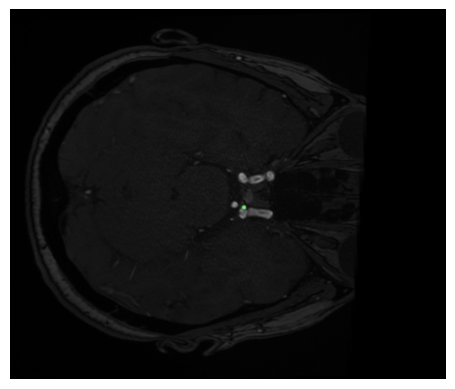

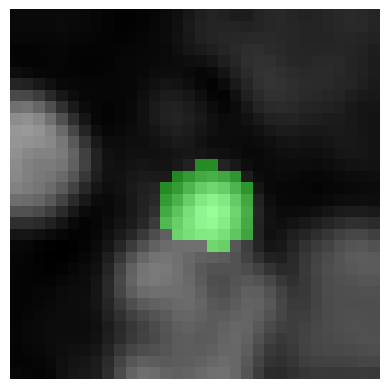

In [31]:



def xyz2zxy(X):
    return np.transpose(X, (2, 0, 1))



mra_nii = nib.load(f"C:\\Users\\Usuari\\Desktop\\test-final\\010\\TOF_010_0000.nii.gz")
mra_a = np.array(mra_nii.get_fdata(), dtype=np.float32) 
mra_a=xyz2zxy(mra_a)
mra_a_slice=mra_a[95,:,:]


mra_nii = nib.load(f"C:\\Users\\Usuari\\Desktop\\test-final\\010\\TOF_010_pred.nii.gz")
pos_a = np.array(mra_nii.get_fdata(), dtype=np.float32) 
pos_a=xyz2zxy(pos_a)
pos_a_slice=pos_a[95,:,:].astype(np.int64)


mra_nii = nib.load(f"C:\\Users\\Usuari\\Desktop\\test-final\\010\\aneurysms.nii.gz")
gt = np.array(mra_nii.get_fdata(), dtype=np.float32) 
gt=xyz2zxy(gt)
gt_slice=gt[95,:,:].astype(np.int64)

# Combine the masks to create a single mask with different colors
combined_mask = np.zeros((gt_slice.shape[0], gt_slice.shape[1], 3))
combined_mask[..., 1] = pos_a_slice  # Green channel for mask 1
combined_mask[..., 0] = gt_slice  # Red channel for mask 2

# Plot the image with the mask overlay
plt.imshow(mra_a_slice, cmap='gray')
plt.imshow(combined_mask, alpha=0.4)
plt.axis('off')
plt.show()


plt.imshow(mra_a_slice[348-16:348+16,411-16:411+16], cmap='gray')
plt.imshow(combined_mask[348-16:348+16,411-16:411+16], alpha=0.4)
plt.axis('off')
plt.show()

        

In [25]:
# bOotrstraping algorithm to obtain 95% confidence intervals
# Assuming you have an array of data named 'data'
data = np.array(vs)

# Set the number of bootstrap samples
n_bootstrap = 1000

# Set the desired statistic (mean in this example)
statistic = np.mean

# Generate bootstrap samples and compute the statistic
bootstrap_statistics = []
for _ in range(n_bootstrap):
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    bootstrap_statistic = statistic(bootstrap_sample)
    bootstrap_statistics.append(bootstrap_statistic)

# Compute the confidence interval
lower_bound = np.percentile(bootstrap_statistics, 2.5)
upper_bound = np.percentile(bootstrap_statistics, 97.5)

# Print the confidence interval
print("95% Confidence Interval: [{:.2f}, {:.2f}]".format(lower_bound, upper_bound))


95% Confidence Interval: [0.29, 0.56]


In [33]:
dice_mod = [0.6741935483870968,0.6741935483870968,
 0.1333333333333333,
 0.7360482654600302,
 0.4288888888888889,
 0,
 0.8283482568108211,
 0.0,
 0,
 0,
 0.0,
 0.0,
 0.5543710021321961,0.5543710021321961,0.5543710021321961,0.5543710021321961,
 0, 0,
 0.8700486448922863,
 0,
 0.4776119402985075, 0.4776119402985075,
 0.5569917743830788, 0.5569917743830788,
 0.0,0.0,
 0,0,
 0.22242990654205608,
 0,
 0.43868739205526774, 0.43868739205526774,
 0.7757255936675462,
 0.7535680304471931,
 0, 0,
 0.3088235294117647,
 0,
 0]

In [38]:
hausdorff_mm_mod=[13.172041351079184,13.172041351079184,
 22.302432460892362,
 1.0843142603599871,
 26.272006330543945,
 np.nan,
 1.120826519918031,
 52.38506548165481,
 np.nan,
 np.nan,
 10.239080840928226,
 51.61705333349962,
 8.278515866451611, 8.278515866451611, 8.278515866451611, 8.278515866451611,
 np.nan, np.nan,
 0.35643736515659125,
 np.nan,
 25.531751102350647, 25.531751102350647,
 17.369771938202952, 17.369771938202952,
 11.791126413672465, 11.791126413672465,
 np.nan,np.nan,
 30.627622492987555,
 np.nan,
 3.559844013708667, 3.559844013708667,
 1.222663724720425,
 0.5675659295961184,
 np.nan,np.nan,
 14.760536340644745,
 np.nan,
 np.nan]

In [36]:
vs_mod = [0.8096774193548387,0.8096774193548387,
 0.1428571428571429,
 0.9698340874811463,
 0.5977777777777777,
 0.0,
 0.8866450752524291,
 0.00022502602753582401,
 0.0,
 0.0,
 0.4723618090452262,
 0.7829937998228521, 
 0.7654584221748401,0.7654584221748401,0.7654584221748401,0.7654584221748401,
 0.0, 0.0,
 0.9798471160528145,
 0.0,
 0.8735271013354281, 0.8735271013354281,
 0.6933019976498238,0.6933019976498238,
 0.4237623762376238,0.4237623762376238,
 0.0, 0.0,
 0.5448598130841121,
 0.0,
 0.44134449315796465, 0.44134449315796465,
 0.8738786279683377,
 0.768791627021884,
 0.0, 0.0,
 0.75,
 0.0,
 0.0]

In [39]:
pos=['ICA','ICA','ACA','ACA','ACA','ICA','MCA','ACA','MCA','MCA','ICA','MCA','MCA','MCA','MCA','MCA','B','ICA','ICA','ICA','MCA','MCA','ICA','ICA','ICA','ICA','MCA','ACA','MCA','ICA',
'MCA','ACA','MCA','ACA','MCA','ICA','MCA','MCA','MCA'
]

In [40]:
phase=[1,1,1,2,2,2,3,4,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,2,1,1,1,1,1,1,3,1,1,1,1,2,1,1,1]

In [41]:
data= {'DSC' : dice_mod,'MHD': hausdorff_mm_mod , 'VS' : vs_mod, 'Position': pos, 'PHASE_score': phase}
df = pd.DataFrame(data)
df

<Axes: xlabel='Position', ylabel='VS'>

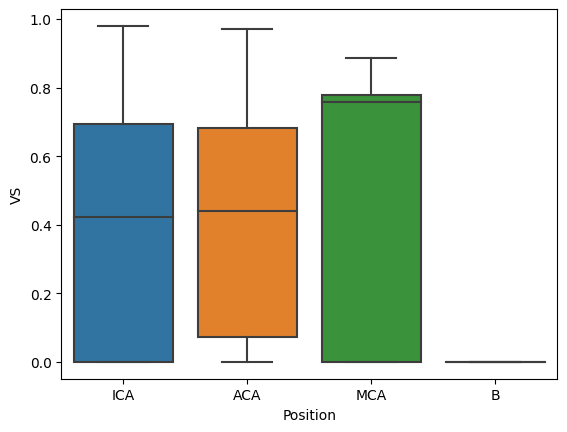

In [44]:

sns.boxplot(data=df, x="Position", y="VS")

<Axes: xlabel='PHASE_score', ylabel='VS'>

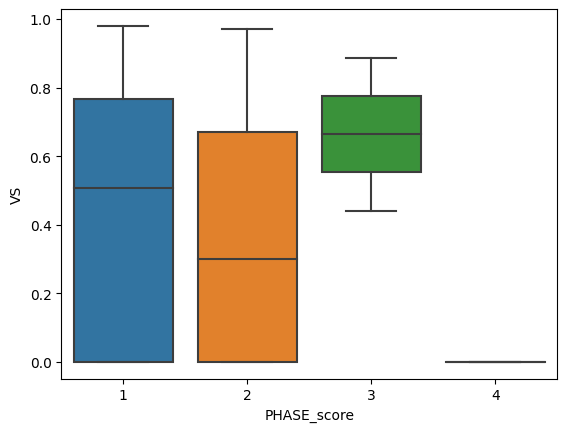

In [46]:
sns.boxplot(data=df, x="PHASE_score", y="VS")

In [49]:

res = stat()
res.anova_stat(df=df, res_var='DSC', anova_model='DSC ~ PHASE_score')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
PHASE_score,1.0,0.008548,0.008548,0.086403,0.770443
Residual,37.0,3.660296,0.098927,NaN,NaN
